# Autoencoder

## imports

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Activation, Reshape
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

## utility functions

In [2]:
def show_image(img, target):
    print("Target is: ", target)
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    plt.show()

## data steps

### load the data

In [3]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

### preprocess the data

In [4]:
# we assume that at least one pixel is lit up in the image since mnist is a cleaned dataset
# this means we can check max value to see if we have preprocessed the data already
if(np.max(train_x) > 1):
    train_x = train_x / 255
if(np.max(test_x) > 1):
    test_x = test_x / 255

Target is:  5


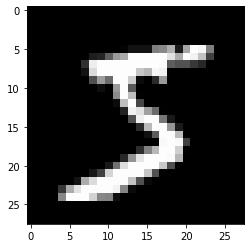

In [5]:
show_image(train_x[0], train_y[0])

In [6]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


## create the model

### dense model

In [7]:
def create_dense_model(img_size):
    encoder_inputs = Input(shape=(img_size,img_size,1))
    x = Flatten()(encoder_inputs)
    x = Dense(64)(x)
    encoder_outputs = Activation(relu)(x)
    x = Dense(img_size*img_size)(encoder_outputs)
    decoder_outputs = Reshape((img_size,img_size,1))(x)
    
    encoder = Model(encoder_inputs, encoder_outputs, name="encoder")
    autoencoder = Model(encoder_inputs, decoder_outputs, name="autoencoder")
    #autoencoder.summary()
    autoencoder.compile(loss="mse", optimizer="adam")
    return autoencoder, encoder

### convolutional model

In [8]:
def create_convolutional_model(img_size):
    encoder_inputs = Input(shape=(img_size,img_size,1))
    x = Conv2D()
    return

## train function

## driver

In [9]:
autoencoder, encoder = create_dense_model(train_x.shape[1])

In [10]:
early_stopping = EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', min_delta=0, patience=2, factor=0.5)
hist = autoencoder.fit(train_x, train_x, shuffle=True, epochs=20, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
1875/1875 [==============================] - 2s 919us/step - loss: 0.0302
Epoch 2/20
1875/1875 [==============================] - 2s 910us/step - loss: 0.0121
Epoch 3/20
1875/1875 [==============================] - 2s 898us/step - loss: 0.0113
Epoch 4/20
1875/1875 [==============================] - 2s 895us/step - loss: 0.0110
Epoch 5/20
1875/1875 [==============================] - 2s 908us/step - loss: 0.0107
Epoch 6/20
1875/1875 [==============================] - 2s 929us/step - loss: 0.0107
Epoch 7/20
1875/1875 [==============================] - 2s 901us/step - loss: 0.0107
Epoch 8/20
1875/1875 [==============================] - 2s 905us/step - loss: 0.0107
Epoch 9/20
1875/1875 [==============================] - 2s 896us/step - loss: 0.0107
Epoch 10/20
1875/1875 [==============================] - 2s 927us/step - loss: 0.0106
Epoch 11/20
1875/1875 [==============================] - 2s 919us/step - loss: 0.0106
Epoch 12/20
1875/1875 [==============================] - 2s 903

In [11]:
autoencoder.evaluate(test_x, test_x)

313/313 [==============================] - 0s 759us/step - loss: 0.0103


0.010287214070558548